## Lets create framework to test algorithms and prepare submissions

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
## brew cask install anybar
%%bash 
open -a AnyBar

In [3]:
# %install_ext https://raw.githubusercontent.com/ermakovpetr/ipython-anybar/master/ipython_anybar.py
%load_ext ipython_anybar
%ipython_anybar_connect 1738

Connect to localhost:1738


This anybar app is very useful to understand is computation complete or not. I highly recommend it.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_data(X, y):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return train_test_split(X, y)

In [5]:
from sklearn.metrics import log_loss

def test_solution(classifier, X, y):
    np.random.seed(42)
    X_train, X_test, y_train, y_test = prepare_data(X, y)
    classifier.fit(X_train, y_train)
    return log_loss(y_test, classifier.predict_proba(X_test))

In [6]:
def create_submission(classifier, X):
    answer = classifier.predict(X)
    y = pd.DataFrame(answer)
    y.to_csv('submission.csv', header=None, index=False)

## Data observation

In [51]:
X = pd.read_csv('x_train.csv', sep=';')
y = pd.read_csv('y_train.csv', sep=';', header=None)
X.head()

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed
0,39,10,3,17,24.444444,1,5,0.400000,2650000,1375,21,2
1,21,22,19,55,17.045455,1,6,0.333333,5614000,3825,51,4
2,5,6,1,6,8.400000,0,1,1.000000,857000,1150,14,1
3,21,2,5,6,19.000000,0,1,0.000000,120000,0,1,1
4,4,5,1,5,9.600000,0,1,1.000000,857000,1075,12,1


In [9]:
X[X['maxPlayerLevel']==0].describe()

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed
count,2284.0,2284.0,2284.000000,2284.000000,2284.000000,2284.0,2284.0,2284.0,2284.000000,2284.000000,2284.0,2284.0
mean,0.0,1.0,1.012259,1.012259,2.949650,0.0,0.0,0.0,122085.814361,245.063485,0.0,1.0
std,0.0,0.0,0.128431,0.128431,0.429533,0.0,0.0,0.0,24934.211997,34.540446,0.0,0.0
min,0.0,1.0,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0
25%,0.0,1.0,1.000000,1.000000,3.000000,0.0,0.0,0.0,113000.000000,250.000000,0.0,1.0
50%,0.0,1.0,1.000000,1.000000,3.000000,0.0,0.0,0.0,113000.000000,250.000000,0.0,1.0
75%,0.0,1.0,1.000000,1.000000,3.000000,0.0,0.0,0.0,125000.000000,250.000000,0.0,1.0
max,0.0,1.0,3.000000,3.000000,7.000000,0.0,0.0,0.0,238000.000000,250.000000,0.0,1.0


maxPlayerLevel looks strange, because part of players with level 0 returned to lower levels.

In [38]:
X[X['maxPlayerLevel']==0][['totalScore', 'totalBonusScore', 'numberOfDaysActuallyPlayed']].mean()

totalScore                    122085.814361
totalBonusScore                  245.063485
numberOfDaysActuallyPlayed         1.000000
dtype: float64

To much score for level 0, looks strange. But maybe you get some score during registration and then lose it?

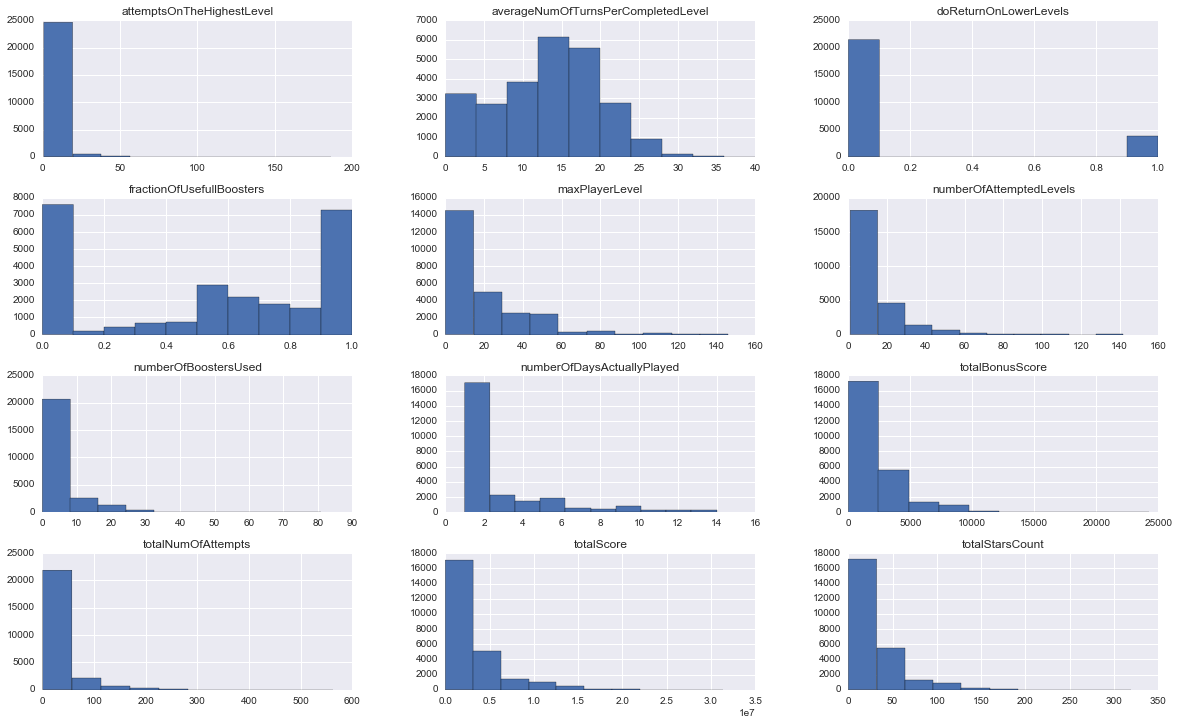

In [14]:
X.hist(figsize=(20,12));

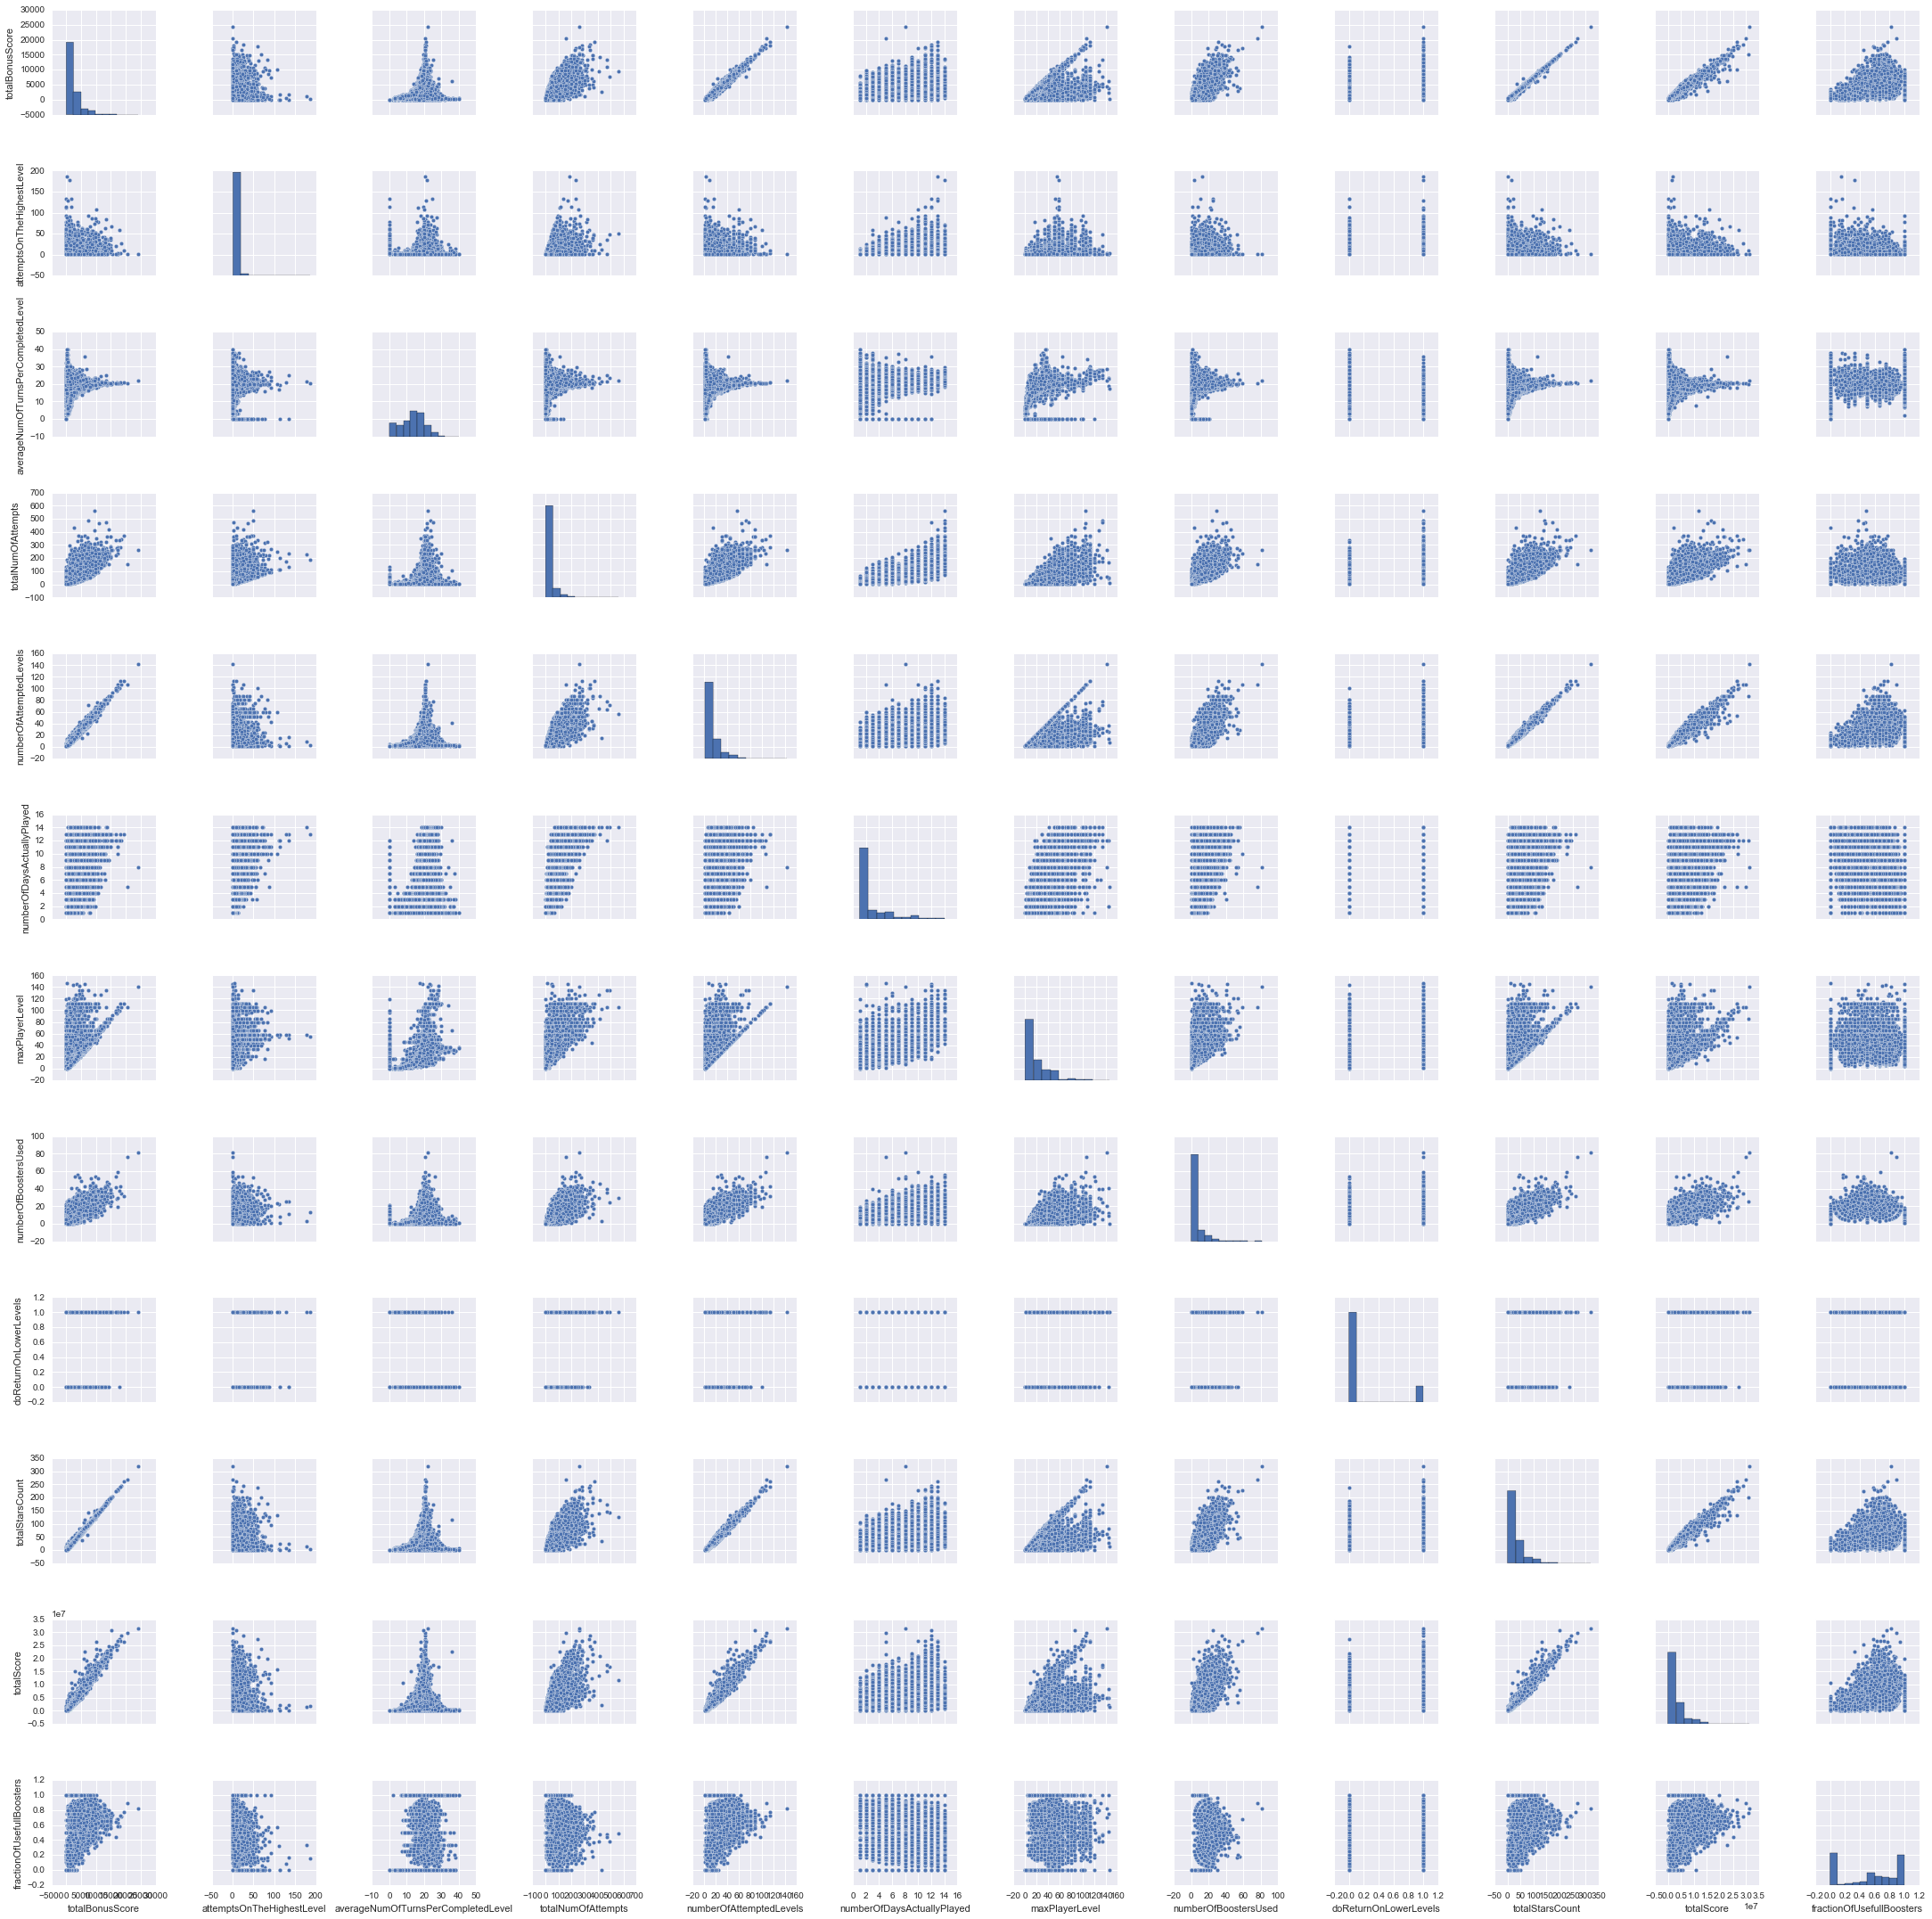

In [11]:
sns.pairplot(X[features]);

There is a lot of correlation between features.

## Data modification

In [16]:
def upgrade_with_div(X):
    df = pd.DataFrame()
    for i in X.columns:
        for j in X.columns:
            if (not('_' in i)) and (not ('_' in j)):  # защита от генерации новых фич на основе синтетических признаков, иначе их становится слишком много
                df[i + '_/_' + j] = X[i] / (e**-8 + X[j]) # защита от деления на ноль
    for i in X.columns:
        df[i] = X[i]
        
    return df

This made the biggest difference in score.

In [17]:
def upgrade_with_log1p(X):
    df = pd.DataFrame()
    for i in X.columns:
        if (not('_' in i)):
            df[i + '_log1p'] = np.log1p(X[i])
    for i in X.columns:
        df[i] = X[i]
        
    return df

This way I tried to normalize data and it was useful for linear algorithms.

In [18]:
def upgrade_with_multiply(X):
    df = pd.DataFrame()
    for i in X.columns:
        for j in X.columns:
            if (not('_' in i)) and (not ('_' in j)):
                df[i + '_*_' + j] = X[i] * X[j]
    for i in X.columns:
        df[i] = X[i]
        
    return df

In [10]:
def upgrade_with_plus(X):
    df = pd.DataFrame()
    for i in X.columns:
        for j in X.columns:
            if (not('_' in i)) and (not ('_' in j)):
                df[i + '_+_' + j] = X[i] + X[j]
    for i in X.columns:
        df[i] = X[i]
        
    return df

Multiplication and addition didn't work well. 

In [28]:
def upgrade_with_minus(X):
    df = pd.DataFrame()
    for i in X.columns:
        for j in X.columns:
            if (not('_' in i)) and (not ('_' in j)):
                df[i + '_-_' + j] = X[i] - X[j]
    for i in X.columns:
        df[i] = X[i]
        
    return df

It works great with tree algorithms.

In [20]:
def upgrade_with_exp(X):
    for i in X.columns:
        if (not('_' in i)):
            X[i + '_exp'] = exp(X[i])

In [13]:
def find_lusers(X):
    return X[X['maxPlayerLevel']==0].index

In [14]:
def minus_default(X):
    X[['totalScore', 'totalBonusScore', 'numberOfDaysActuallyPlayed']] -= X[X['maxPlayerLevel']==0][['totalScore', 'totalBonusScore', 'numberOfDaysActuallyPlayed']].mean()
    return X

Then I subtracted scores that was given during registration in the game to understand better how much score user gain or lose during two weeks. It should work good with linear algorithms.

In [15]:
def upgrade_with_lasso(X, y):
    clf = Lasso(alpha=0.044, selection='random')
    X = upgrade_with_log1p(X)

    np.random.seed(42)
    X_train, X_test, y_train, y_test = prepare_data(X, y)
    clf.fit(X_train, y_train)

#     clf.fit(X, y)
    return clf.predict(X)

This way I tried to ensemble algorithms, but it didn't work well.

In [26]:
from xgboost import XGBClassifier

def upgrade_with_xgb(X, y):
    clf = XGBClassifier()
    X = upgrade_with_div(X)
    clf.fit(X, y)
    
    return clf.predict(X)

In [58]:
def clasterize_big_vals(number):
    if number < 5:
        return 0
    if number < 10:
        return 1
    if number < 20:
        return 2
    if number < 45:
        return 3
    if number < 80:
        return 4
    if number < 150:
        return 5
    if number < 300:
        return 6
    return 7

def clasterize_small_vals(number):
    if number < 2:
        return 0
    if number < 3:
        return 1
    if number < 10:
        return 2
    return 3


def clasterize_vals(X):
    X['totalNumOfAttempts_clust'] = X.totalNumOfAttempts.apply(clasterize_big_vals)
    X['attemptsOnTheHighestLevel_clust'] = X.attemptsOnTheHighestLevel.apply(clasterize_small_vals)
    X['maxPlayerLevel_clust'] = X.maxPlayerLevel.apply(clasterize_small_vals)
    return X

This worked great with linear algorithms because it added nonlinearity to information.

In [18]:
def upgrade_with_means(X):
    df = pd.DataFrame()
    for i in X.columns:
        if not('_' in i):
            df[i + '_mean'] = mean(X[i])

    for i in X.columns:                
        df[i] = X[i]
    return df

I assumed that adding means and stds will give additional information to decision trees and regression. But it never worked out well.

In [19]:
def upgrade_with_stds(X):
    df = pd.DataFrame()
    for i in X.columns:
        if '_' in i:
            pass
        else:
            df[i + '_std'] = std(X[i])

    for i in X.columns:                
        df[i] = X[i]
    return df

In [29]:
def drop_dumb_features(X, y):
    clf = XGBClassifier()
    clf.fit(X, y)

    X.drop(X.columns[clf.feature_importances_ < 0.002], inplace=True, axis=1)

It is very useful to drop weak features during feature generation to speed things up. Also it's good for trees algorithms, because it always choose subset of parameters for each tree.

### Linear models

In [52]:
from sklearn.linear_model import Lasso

X = pd.read_csv('x_train.csv', sep=';')
y = ravel(pd.read_csv('y_train.csv', header=None))

clf4 = Lasso(alpha=0.044, selection='random')

X = clasterize_vals(X)
X = upgrade_with_log1p(X)


np.random.seed(42)
X_train, X_test, y_train, y_test = prepare_data(X, y)

clf4.fit(X_train, y_train)
log_loss(y_test, clf4.predict(X_test))

0.39525257071502751

In [24]:
from sklearn.linear_model import LogisticRegressionCV

X = pd.read_csv('x_train.csv', sep=';')
y = ravel(pd.read_csv('y_train.csv', header=None))

X = upgrade_with_log1p(X)
X = upgrade_with_div(X)

clf6 = LogisticRegressionCV()
clf6.fit(X, y)

np.random.seed(42)
X_train, X_test, y_train, y_test = prepare_data(X, y)

clf6.fit(X_train, y_train)
log_loss(y_test, clf6.predict_proba(X_test))

0.37248491032969588

This score is really good, but leaderboard score was much worse, it seems I overfitted a bit.

In [ ]:
0.37468961391699607 - logreg - log1p
0.37248491032969588 - logreg - log1p - div
0.3736334050621915  - logreg - clast - log1p - div
0.37817721485288264 - xgb - log1p - div

### XGB

In [34]:
from xgboost import XGBClassifier

clf2 = XGBClassifier()
X = pd.read_csv('x_train.csv', sep=';')
y = ravel(pd.read_csv('y_train.csv', header=None))
X = clasterize_vals(X)
# X = upgrade_with_minus(X)

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

clf2.fit(X_train, y_train)
print log_loss(y_test, clf2.predict_proba(X_test))


# test_solution(clf2, X, y)

# clf2.fit(X, y)
# X_sub = pd.read_csv('x_test.csv', sep=';')
# X_sub = clasterize_vals(X_sub)
# X_sub = upgrade_with_minus(X_sub)
# answer = clf2.predict_proba(X_sub)
# y = pd.DataFrame(answer)
# y[1].to_csv('submission.csv', header=None, index=False)

0.375081777772


### XGBoost, подбор парметров

* Set learning_rate to moderate value ($ \eta \in [0.05, 0.3]$), and select optimal number of trees

* Set trees' parameters, begin from most important (max_depth, min_child_weight, gamma, subsample, colsample_bytree)

* Adjust regularizations ($ \lambda, \alpha $)

* Make learning_rate slower and number of trees bigger proportionally and simultaneously

In [ ]:
clf2 = XGBClassifier(learning_rate=0.0685, n_estimators=121, max_depth=3, 
                 min_child_weight=32, gamma=0.7, subsample=0.65, colsample_bytree=0.95)

score 0.38209563608456021

(1.0, 0.65982420459250812)
(112.0, 0.37988453192819299)
(223.0, 0.38026596982894895)
(334.0, 0.38146654521602585)
(445.0, 0.38208073380376639)
(556.0, 0.38302109335084644)
(667.0, 0.38397353582399169)
(778.0, 0.38526216730539808)
(889.0, 0.38615793320966862)
(1000.0, 0.38710911825579919)
112 0.379884531928


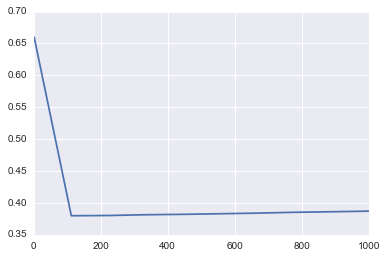

In [43]:
from sklearn.model_selection import cross_val_score

score = []
values_to_try = linspace(1, 1000, num=10)

X = pd.read_csv('x_train.csv', sep=';')
y = ravel(pd.read_csv('y_train.csv', header=None))

for val in values_to_try:
    clf2 = XGBClassifier(learning_rate=0.0685, n_estimators=int(val), max_depth=3, 
                     min_child_weight=32, gamma=0.7, subsample=0.65, colsample_bytree=0.95)

    X = upgrade_with_minus(X)
    drop_dumb_features(X, y)
    X = upgrade_with_div(X)
    drop_dumb_features(X, y)
    
    print (val, mean(cross_val_score(clf2, X, y, cv=7, scoring='neg_log_loss')) * (-1))
    score.append((val, mean(cross_val_score(clf2, X, y, cv=7, scoring='neg_log_loss')) * (-1)))

score = np.array(score)
plot(score[:,0], score[:,1])
print int(score[:,0][score[:,1].argmin()]), min(score[:,1])


# clf2 = XGBClassifier(learning_rate=0.0685, n_estimators=121, max_depth=3, 
#                      min_child_weight=32, gamma=0.7, subsample=0.65, 
#                      colsample_bytree=0.95, seed=76)

# X = upgrade_with_minus(X)
# drop_dumb_features(X, y)
# X = upgrade_with_div(X)
# drop_dumb_features(X, y)

# clf2.fit(X, y)
# X_sub = pd.read_csv('x_test.csv', sep=';')
# X_sub = upgrade_with_minus(X_sub)
# X_sub = upgrade_with_div(X_sub)
# good_features = X.columns
# answer = clf2.predict_proba(X_sub[good_features.values])
# y = pd.DataFrame(answer)
# y[1].to_csv('submission.csv', header=None, index=False)

In [ ]:
0.38224669215239881
0.382916387614

In [ ]:
0.38240229408636806 minus
0.38226492378367033 minus drop 
0.38224669215239881 minus drop div drop

0.384153021919 0.00204290826411
0.0777777777778


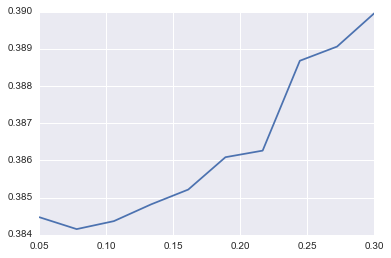

In [364]:
X = pd.read_csv('x_train.csv', sep=';')
y = ravel(pd.read_csv('y_train.csv', header=None))
result = []

values_to_try = linspace(0.05, 0.3, 10)
for val in values_to_try:
    clf = XGBClassifier(learning_rate=val)
    clf.fit(X, y)
    result.append((val, mean(cross_val_score(clf, X, y, cv=2, scoring='neg_log_loss')) * (-1)))

result = np.array(result)
plot(result[:,0], result[:,1])

print min(result[:,1]), std(result[:,1])
print result[:,0][result[:,1].argmin()]

### Auto parameters adjusting script

In [ ]:
for feature in ['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 
                'gamma', 'subsample', 'colsample_bytree']:
    scope = 1
    result_std = 1
    center = parameters[feature]
    print feature
    
    while result_std > 0.00018:
        result = []
        scope = scope * 0.7

        values_to_try = linspace(center * (1-scope), center * (1+scope), 10)
        for val in values_to_try:
            parameters[feature] = val
            clf = XGBClassifier(learning_rate=parameters['learning_rate'], n_estimators=int(parameters['n_estimators']), 
                                max_depth=int(parameters['max_depth']), min_child_weight=int(parameters['min_child_weight']),
                                gamma=parameters['gamma'], subsample=parameters['subsample'], 
                                colsample_bytree=parameters['colsample_bytree'])
            
            X = upgrade_with_minus(X)
            drop_dumb_features(X, y)
            X = upgrade_with_div(X)
            drop_dumb_features(X, y)

            clf.fit(X, y)
            result.append((val, mean(cross_val_score(clf, X, y, cv=2, scoring='neg_log_loss')) * (-1)))

        result = np.array(result)
        plot(result[:,0], result[:,1])

        print min(result[:,1]), std(result[:,1])
        print result[:,0][result[:,1].argmin()]
        center = result[:,0][result[:,1].argmin()]
        result_std = std(result[:,1])
        
    parameters[feature] = center
    
print parameters

I never had time to run it till the end, but it works somehow.